In [1]:
import sys
sys.path.append("..")

In [2]:
from files.utils import empty_lists, annotator_counter, target_counter, label_counter, pie_plot, word_cloud, bar_plot, data_importer
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [3]:
data_df = data_importer()
post_id = []
annotators = []
rationales = []
post = []

for value in data_df.values():
    post_id.append(value['post_id'])
    annotators.append(value['annotators'])
    rationales.append(value['rationales'])
    post.append(value['post_tokens'])

d = {
    'post_id': post_id,
    'annotations': annotators,
    'rationales': rationales,
    'posts': post
}
data_table = pd.DataFrame(data = d)
data_table

,post_id,annotations,rationales,posts
0,1179055004553900032_twitter,"[{'label': 'normal', 'annotator_id': 1, 'targe...",[],"[i, dont, think, im, getting, my, baby, them, ..."
1,1179063826874032128_twitter,"[{'label': 'normal', 'annotator_id': 1, 'targe...",[],"[we, cannot, continue, calling, ourselves, fem..."
2,1178793830532956161_twitter,"[{'label': 'normal', 'annotator_id': 4, 'targe...",[],"[nawt, yall, niggers, ignoring, me]"
3,1179088797964763136_twitter,"[{'label': 'hatespeech', 'annotator_id': 1, 't...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[<user>, i, am, bit, confused, coz, chinese, p..."
4,1179085312976445440_twitter,"[{'label': 'hatespeech', 'annotator_id': 4, 't...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[this, bitch, in, whataburger, eating, a, burg..."
...,...,...,...,...
20143,9989999_gab,"[{'label': 'offensive', 'annotator_id': 217, '...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,...","[if, ur, still, on, twitter, tell, carlton, i,..."
20144,9990225_gab,"[{'label': 'offensive', 'annotator_id': 220, '...","[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,...","[when, i, first, got, on, here, and, said, i, ..."
20145,9991681_gab,"[{'label': 'offensive', 'annotator_id': 206, '...",[],"[was, macht, der, moslem, wenn, der, zion, geg..."
20146,9992513_gab,"[{'label': 'hatespeech', 'annotator_id': 209, ...","[[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,...","[it, is, awful, look, at, world, demographics,..."


In [4]:
# Total number of rows:
print(f"Total number of rows in the dataset: {len(data_table)}")

Total number of rows in the dataset: 20148


## Missing Values Identification

In [5]:
# Check for missing values
missing_post_ids = data_table["post_id"].isnull().sum()

empty_annotations = annotator_counter(data_table)

empty_targets = target_counter(data_table)

empty_labels = label_counter(data_table)

empty_rationales = empty_lists(data_table, 'rationales')

empty_posts = empty_lists(data_table, 'posts')

print(f"Number of unique post_ids: {data_table['post_id'].nunique()}")
print(f"Total number of rows with missing post_ids: {missing_post_ids}")
print(f"Total number of rows with empty post lists: {empty_posts}")
print(f"Total number of rows with empty annotations: {empty_annotations}")
print(f"Total number of rows with empty targets: {empty_targets}")
print(f"Total number of rows with empty labels: {empty_labels}")
print(f"Total number of rows with empty rationales lists: {empty_rationales}")

Number of unique post_ids: 20148
Total number of rows with missing post_ids: 0
Total number of rows with empty post lists: 0
Total number of rows with empty annotations: 3931
Total number of rows with empty targets: 3931
Total number of rows with empty labels: 0
Total number of rows with empty rationales lists: 8733


#### Observations: 
- **No Missing Post IDs or Posts:** The dataset is complete with respect to post IDs and posts. Every entry has a unique identifier (post_id) and corresponding post ensuring that no data is missing.

- **Missing Annotations and Targets:** A total of 3,931 rows have missing annotations, which directly correlates with the missing targets. This relationship confirms that rows missing annotations are only missing targets, and there are no cases where labels are missing from the dataset which can be justified by 0 missing post lists in the dataset. All these labels play a crucial role in the integrity of the dataset. Moreover, for the missing targets there are two categories:
    - Rows with empty lists ([]): Which is a result of randomly missing data.
    - Rows with ["None"]: Indicates that the corresponding label is mostly "normal" or missing in few cases.

    As a solution to this problem, I am going to replace empty target lists ([]) with ["None"] and retain the majority from the annotations of every post. However, as my primary goal is to create a toxicity speech detector these rows will not be removed as target variable do not play a key role in it. The focus will remain on using the available annotations for training the model, thereby ensuring a more comprehensive dataset.
    
- **Empty Rationale Lists:** Approximately 43% of the dataset (8,733 out of 20,148 rows) contains empty rationale lists, which presents a challenge for model training and evaluation. Removing these rows would result in a substantial loss of data and increase the risk of overfitting. To mitigate this, I am going to generate a list of zeros for each empty rationale, corresponding to the length of the post tokens. Additionally, I will implement stratified k-fold cross-validation to ensure a balanced and robust evaluation of the model's performance, leveraging the available data more effectively.

## Inconsistent Rationales

In [6]:
faulty_ids = []
for _, row in data_table.iterrows():
    posts = row['posts']
    for rationale in row['rationales']:
        if len(rationale) != len(posts):
            faulty_ids.append(row['post_id'])
    
print(faulty_ids)

['24439295_gab']


### Observation: 
The **inconsistent_rationales (data_table)** identifies post IDs where the length of the lists in rationales does not match the length of the posts_tokens lists. **The row with the post_id ['24439295_gab'] is removed** to ensure that each token in a post has a corresponding rationale, which is critical for maintaining data integrity and consistency.

## Pie Chart For Label Distribution

In [7]:
list = []
for annotators in data_table['annotations']:
    for annotations in annotators:
        label = annotations.get('label', '')
        if label not in [None, "", '', 'None']:
            list.append(label)
label_counts = pd.Series(list).value_counts()
print(label_counts)

normal        24449
hatespeech    18070
offensive     17925
Name: count, dtype: int64


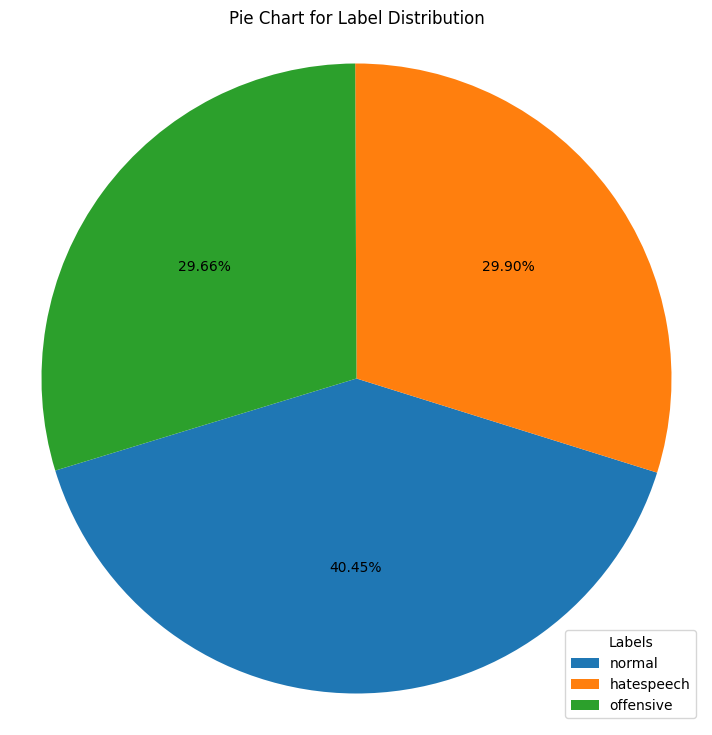

In [8]:
pie_plot(label_counts, 'Pie Chart for Label Distribution')

## Word Cloud For Posts Words Distribution

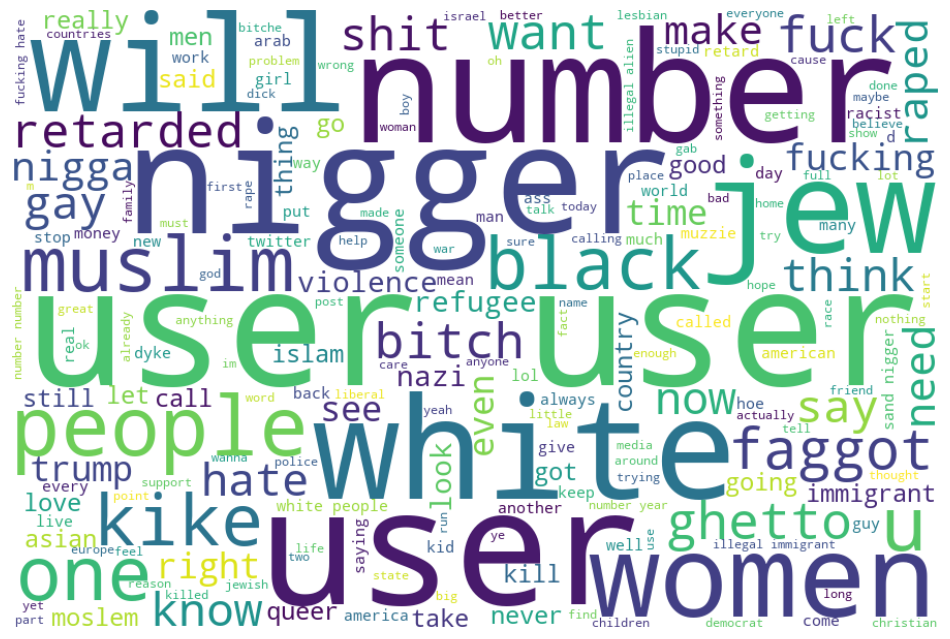

In [9]:
total_words = []
for post in data_table['posts']:
    total_words.extend(post) 
word_cloud(total_words, 56)

## Bar Chart For Target Distribution

In [10]:
lst = []
for annotators in data_table['annotations']:
    for annotations in annotators:
        targets = annotations.get('target', [])
        for target in targets:
            if target not in [None, "", 'None']:
                lst.append(target)
target_counts = pd.Series(lst).value_counts()
print(target_counts)

African         10015
Islam            6686
Women            6126
Jewish           5961
Homosexual       5617
Other            4708
Refugee          3100
Arab             2907
Caucasian        2359
Men              1758
Asian            1350
Hispanic         1299
Christian         270
Disability        221
Minority          188
Heterosexual      141
Economic           90
Hindu              89
Nonreligious       87
Indigenous         83
Indian             81
Buddhism           12
Bisexual            8
Asexual             5
Name: count, dtype: int64


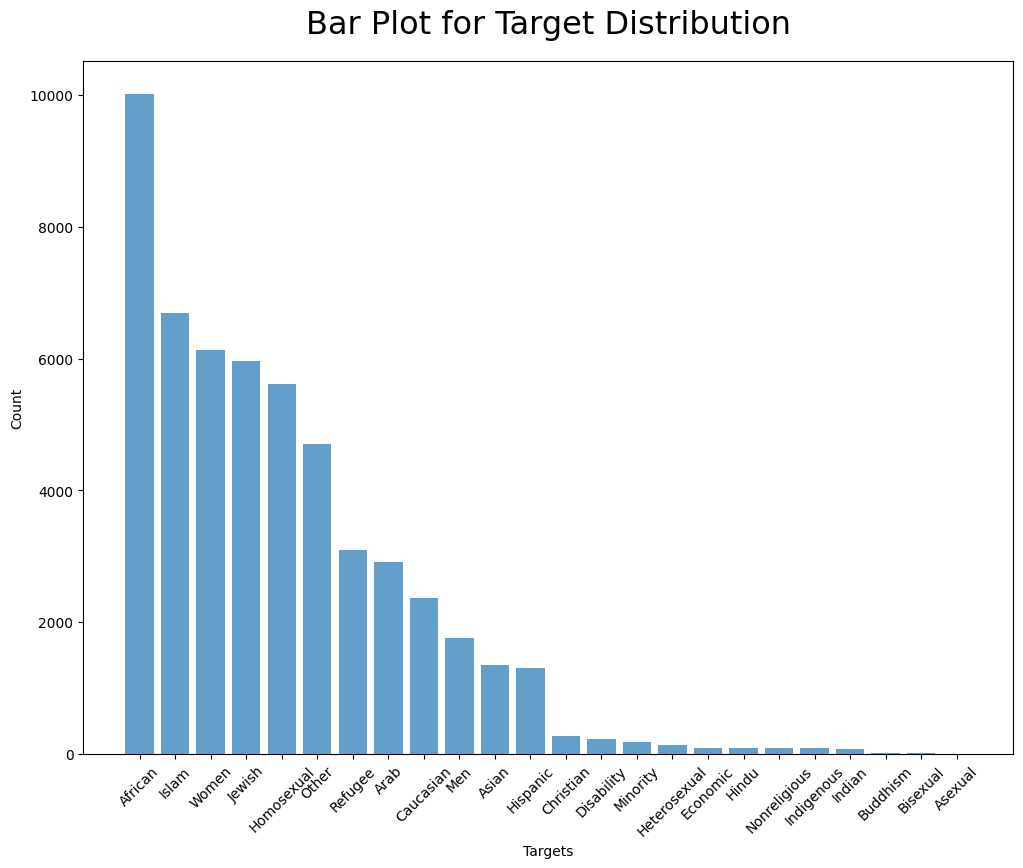

In [11]:
bar_plot(target_counts, 'Bar Plot for Target Distribution', 'Targets')

The final_target_list below consists of all the targets with more than 500 related posts as shown in the above graph. This list will be later used in the preprocessing of the dataset.

final_target_list = ['African', 'Islam', 'Women', 'Jewish', 'Homosexual', 'Refugee', 'Arab', 'Caucasian', 'Men', 'Asian', 'Hispanic']

**NOTE:** "Other" is removed from the list as it does not make any sense.

## Bar Plot for Rationale Words Distribution

In [12]:
lst_words = []

for _, row in data_table.iterrows():
    post = row['posts']
    for rationales in row['rationales']:
        for words, ration in zip(post, rationales):
            if ration == 1 and words not in ENGLISH_STOP_WORDS:
                lst_words.append(words)
words_counts = pd.Series(lst_words).value_counts()
print(words_counts)

nigger      5019
kike        2629
white       1677
niggers     1567
retarded    1503
            ... 
aipac          1
marraige       1
aisha          1
haddiths       1
weaken         1
Name: count, Length: 11513, dtype: int64


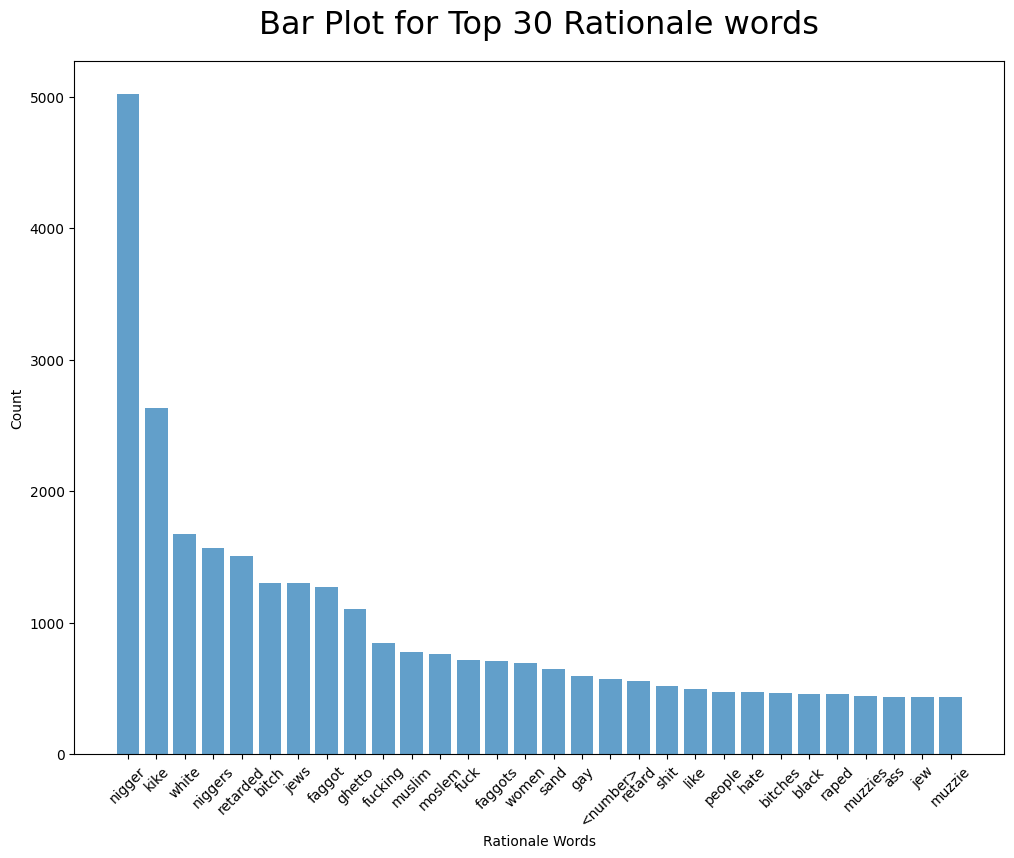

In [13]:
rationale_counts = words_counts.head(30)
bar_plot(rationale_counts, 'Bar Plot for Top 30 Rationale words', 'Rationale Words')

### Observations:
The rationale words consists of some HTML tags and emojis which will be removed in the preprocessing section.